# Feature postprocessing from paper.
- Title:  "Predicting yeast synthetic lethal genetic interactions using protein domains"
- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

### Importing datasets 

#### Link to the github repo where the datasets to be downloaded:
[DOWNLOAD THE DATASETS HERE](https://github.com/leilaicruz/machine-learning-for-yeast/tree/dev_Leila/datasets-for-learning)

In [2]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_SL = "datasets/data-synthetic-lethals.xlsx"
rel_path_nSL="datasets/data-positive-genetic.xlsx"
rel_path_domains="datasets/proteins-domains-from-Pfam.xlsx"

abs_file_path_SL = os.path.join(script_dir, rel_path_SL)
abs_file_path_nSL = os.path.join(script_dir, rel_path_nSL)
abs_file_path_domains = os.path.join(script_dir, rel_path_domains)

# os.chdir('mini_book/docs/') #<-- for binder os.chdir('../')
# os.chdir('../')
my_path_sl= abs_file_path_SL
my_path_non_sl=abs_file_path_nSL
my_path_domains=abs_file_path_domains

data_sl=pd.read_excel(my_path_sl,header=0)
data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_nonsl=pd.read_excel(my_path_non_sl,header=0)

## Building the feature matrix
One matrix for true SL where each row is one pair of SL. Every raw will be a vector of 0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .

### Building the list of proteins domains id per protein pair separately :
- List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
- List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

# For loop for 10000 pairs sampled randomly from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair

for m in random.sample(list(population), 500):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())

In [4]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')
print('We are going to analyze',len((protein_a_list_non)) ,'protein pairs, out of',len(data_nonsl),'positive protein pairs')

We are going to analyze 500 protein pairs, out of 17871 SL protein pairs
We are going to analyze 500 protein pairs, out of 43340 positive protein pairs


### Postprocessing #1:  Remove protein pairs from study if either protein in the pair does not contain any domain

In [5]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[] or protein_list_pair[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)

protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [6]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')
print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 87 out of 500 domains
The empty domain in the nSL were: 78 out of 500 domains


### Feature engineering: Select from each ordered indexes of domain id list which of them appear once, in both or in any of the domains of each protein pair

#### Define function `get_indexes`

In [7]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [8]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    ## To avoid taking repeated domains from one protein of the pairs , lets reduced the domains of each protein from the pairs to their unique members
    protein_a_list_unique=[]
    protein_b_list_unique=[]
    for i in np.arange(0,len(protein_a_list_new)):
        protein_a_list_unique.append(np.unique(protein_a_list_new[i]))
        protein_b_list_unique.append(np.unique(protein_b_list_new[i]))
        
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_unique)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_unique)):
        index_a=[]
        
        pair=[protein_a_list_unique[i],protein_b_list_unique[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    j=0
    for i in pair_a_b_array:  
        array,index,counts=np.unique(i,return_index=True,return_counts=True)
        
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),j]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),j]=1
        j=j+1
    return protein_feat_true

In [9]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)
protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)

### How many ones and twos are in each dataset

In [10]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 1.7609509134932863e-05
fraction of ones in the SL array is 0.0010213515298261062
fraction of twos in the PI array is 7.833614037836356e-06
fraction of ones in the PI array is 0.0009118326740041519


#### Bar plot to visualize these numbers

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

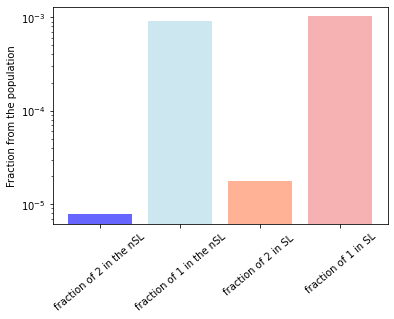

In [11]:
plt.bar(['fraction of 2 in the nSL','fraction of 1 in the nSL'],[index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)),index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns))],alpha=0.6,color=['blue','lightblue']), 

plt.bar(['fraction of 2 in SL ','fraction of 1 in SL'],[index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)),index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns))],alpha=0.6,color=['coral','lightcoral'])

plt.ylabel('Fraction from the population')
plt.yscale('log')
plt.xticks(rotation=40)

#### Adding the labels(response variables) to each dataset

In [12]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

#### Joining both datasets

In [13]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))
print('The number of features are:',feature_post.shape[1])
print('The number of samples are:',feature_post.shape[0])

The number of features are: 3026
The number of samples are: 835


### Postprocessing and exploration of the feature matrix of both datasets

In [14]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

corr_keys=pd.concat([mean,std,lethality],axis=1)

### Viz of the stats

Text(0.5, 1.08, 'Pairplot to see data dependencies with Lethality')

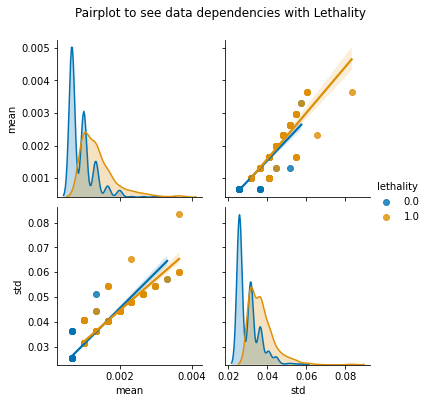

In [15]:
pair=sns.pairplot(corr_keys,hue='lethality',diag_kind='kde',kind='reg',palette='colorblind')
pair.fig.suptitle('Pairplot to see data dependencies with Lethality',y=1.08)

In [16]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_sl=protein_feat_true_pd.drop(columns=['lethality'])
x_nsl=protein_feat_non_true_pd.drop(columns=['lethality'])

X_sl_scaled = scaler.fit_transform(x_sl)
X_nsl_scaled = scaler.fit_transform(x_nsl)

In [18]:
np.shape(X_sl_scaled)

(413, 3025)

## How redundant are each of the protein domains?

In [19]:
def PCA_component_contribution(scaled_matrix,original_data):
    from sklearn.decomposition import PCA

    model = PCA(0.95).fit(scaled_matrix)
    ## apply dimensionality reduction to X_train
    output_pca = model.transform(scaled_matrix)
    
    total=sum(model.explained_variance_)


   
    # number of components , that it will be the number of main axes times the number of original components 
    n_pcs= model.components_.shape[0] # the amount of non redundant protein domains 

    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = original_data.columns
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    

    # LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items(),columns=['pca-component','domain-number'])

    return df,model.components_

In [20]:
df_sl,components_pca_nsl=PCA_component_contribution(X_nsl_scaled,x_nsl)
df_nsl,components_pca_sl=PCA_component_contribution(X_sl_scaled,x_sl)

In [21]:
df_sl.head()

,pca-component,domain-number
0,PC0,135
1,PC1,1519
2,PC2,689
3,PC3,312
4,PC4,503


## which are the shared domains between nSL and SL pairs , in the PCA reduced samples

In [22]:
df_shared_domains=pd.merge(df_sl,df_nsl,how='inner',on='domain-number')
domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_shared_domains['domain-description']=domains_description[df_shared_domains['domain-number']]


df_shared_domains

,pca-component_x,domain-number,pca-component_y,domain-description
0,PC3,312,PC6,C2; C2 domain
1,PC6,339,PC9,CDC50; CDC50/LEM3 family
2,PC10,293,PC8,Beach; BEACH domain
3,PC26,1344,PC36,MAD; Spindle assembly checkpoint component Mad1
4,PC32,2545,PC121,Syja_N; SAC domain
5,PC50,1072,PC70,"Glycos_transf_1; Glycosyl transferase, family 1"
6,PC59,522,PC90,"Cullin; Cullin, N-terminal"
7,PC60,2596,PC159,TIG; IPT domain
8,PC66,376,PC13,"COG2; Conserved oligomeric Golgi complex, subu..."
9,PC67,1582,PC209,NPCC; Nuclear pore complex component


In [23]:
print('The number of shared domains between SL and nSL pairs,after PCA, is = ',len(df_shared_domains), 'out of', len(df_sl)+len(df_nsl), 'so the',100*len(df_shared_domains)/(len(df_sl)+len(df_nsl)),'%')

The number of shared domains between SL and nSL pairs,after PCA, is =  40 out of 569 so the 7.0298769771529 %


## Domains exclusive to SL

In [24]:
df_sl_exclusive=pd.merge(df_sl,df_nsl,how='left',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_sl_exclusive['domain-description']=domains_description[df_sl_exclusive['domain-number']]
df_sl_exclusive[pd.isnull(df_sl_exclusive['pca-component_y'])]

,pca-component_x,domain-number,pca-component_y,domain-description
0,PC0,135,NaN,ATP-synt_ab_Xtn; ATPsynthase alpha/beta subuni...
1,PC1,1519,NaN,Mtc; Tricarboxylate/iron carrier
2,PC2,689,NaN,DUF3128; Protein of unknown function DUF3128
4,PC4,503,NaN,Complex1_LYR; Complex 1 LYR protein
5,PC5,2082,NaN,RXT2_N; Transcriptional regulatory protein RXT...
...,...,...,...,...
284,PC280,2553,NaN,"TAF8_C; Transcription factor TFIID, subunit 8,..."
285,PC281,2630,NaN,TRAM; TRAM domain
286,PC282,314,NaN,CAF1A; Chromatin assembly factor 1 subunit A
288,PC284,1581,NaN,"NPC1_N; Niemann-Pick C1, N-terminal"


In [25]:
print('The number of exclusive domains from SL pairs, after PCA, is = ',len(df_sl_exclusive), 'out of', len(df_sl)+len(df_nsl), 'so the',100*len(df_sl_exclusive)/(len(df_sl)+len(df_nsl)),'%')

The number of exclusive domains from SL pairs, after PCA, is =  290 out of 569 so the 50.966608084358526 %


In [26]:
df_nsl_exclusive=pd.merge(df_sl,df_nsl,how='right',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_nsl_exclusive['domain-description']=domains_description[df_nsl_exclusive['domain-number']]
df_nsl_exclusive[pd.isnull(df_nsl_exclusive['pca-component_x'])]

,pca-component_x,domain-number,pca-component_y,domain-description
40,NaN,1028,PC0,GatB_Yqey; Asn/Gln amidotransferase
41,NaN,1811,PC1,PRAI; N-(5&apos;phosphoribosyl) anthranilate i...
42,NaN,62,PC2,AHSA1; Activator of Hsp90 ATPase homologue 1-like
43,NaN,384,PC3,COPI_assoc; Golgi apparatus membrane protein T...
44,NaN,989,PC4,GLE1; GLE1-like
...,...,...,...,...
279,NaN,553,PC277,DASH_Dad1; DASH complex subunit Dad1
280,NaN,2093,PC278,Rad51; DNA recombination and repair protein Ra...
281,NaN,1309,PC279,LUC7; Luc7-related
282,NaN,2967,PC280,"zf-C2H2_3; N-acetyltransferase ESCO, zinc-finger"


In [27]:
print('The number of exclusive domains from non SL pairs, after PCA, is = ',len(df_nsl_exclusive), 'out of', len(df_sl)+len(df_nsl), 'so the',100*len(df_nsl_exclusive)/(len(df_sl)+len(df_nsl)),'%')

The number of exclusive domains from non SL pairs, after PCA, is =  284 out of 569 so the 49.91212653778559 %


## Let see to the domains-number that get repeated after the PCA analysis , and selecting the most explanatory feature by its explained variance.

In [28]:
duplicated_features_sl=df_sl[df_sl.iloc[:,1].duplicated()]
repeated_features_sl=pd.DataFrame()

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

repeated_features_sl['domain-name']=domains_name[duplicated_features_sl.iloc[:,1]] 
repeated_features_sl['domain-description']=domains_description[duplicated_features_sl.iloc[:,1]]

duplicated_features_nsl=df_nsl[df_nsl.iloc[:,1].duplicated()]
repeated_features_nsl=pd.DataFrame()

repeated_features_nsl['domain-name']=domains_name[duplicated_features_nsl.iloc[:,1]] 
repeated_features_nsl['domain-description']=domains_description[duplicated_features_nsl.iloc[:,1]]

In [29]:
only_sl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='left',on=['domain-name'])
data_only_sl = only_sl_pd[pd.isnull(only_sl_pd['domain-description_y'])]
data_only_sl['domain-description']=data_only_sl['domain-description_x']
data_only_sl.shape,df_sl_exclusive.shape

((42, 4), (290, 4))

In [30]:
only_nsl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='right',on=['domain-name'])
data_only_nsl = only_nsl_pd[pd.isnull(only_nsl_pd['domain-description_x'])]
data_only_nsl

,domain-name,domain-description_x,domain-description_y
0,PF12738,NaN,Sterol_MT_C; Sterol methyltransferase C-terminal
1,PF00183,NaN,ANAPC5; Anaphase-promoting complex subunit 5
2,PF00307,NaN,AcetylCoA_hyd_C; Acetyl-CoA hydrolase/transfer...
3,PF09763,NaN,Ribosomal_L16; Ribosomal protein L10e/L16
4,PF00206,NaN,"AP_endonuc_2; Xylose isomerase-like, TIM barre..."
5,PF12550,NaN,"Sortilin-Vps10; Sortilin, N-terminal"
6,PF00023,NaN,4HBT; Thioesterase domain
7,PF06978,NaN,PAP2; Phosphatidic acid phosphatase type 2/hal...
8,PF00227,NaN,ATG13; Autophagy-related protein 13
9,PF16891,NaN,tRNA-synt_1c; Glutamyl/glutaminyl-tRNA synthet...


In [31]:
shared_domains_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='inner',on=['domain-name'])
shared_domains_pd


,domain-name,domain-description_x,domain-description_y


(0.0, 0.2)

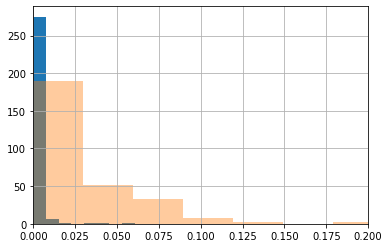

In [32]:
a_sl=x_sl.iloc[:,np.sort(df_sl.iloc[:,1])]
a_sl.describe().loc['mean'].hist(bins=8),
a_sl.describe().loc['std'].hist(bins=8,alpha=0.4)
plt.xlim([0,0.2])

(0.0, 0.2)

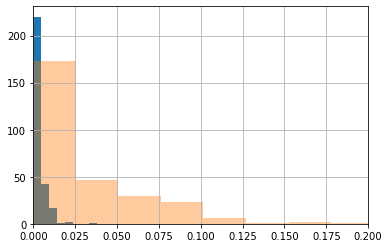

In [33]:
a_nsl=x_nsl.iloc[:,np.sort(df_nsl.iloc[:,1])]
a_nsl.describe().loc['mean'].hist(bins=8),
a_nsl.describe().loc['std'].hist(bins=8,alpha=0.4)
plt.xlim([0,0.2])

### Proof of concept with *BEM1*

- Gather the domains of SL and nSL pairs from BEM1
- Check if the domains for the SL and nSL pairs are inside the most important domains after PCA.

In [34]:
domains_bem1=data_domains[data_domains['name']=='BEM1']['domain-descrip']
sl_bem1=data_sl[data_sl['gene-query-name']=='BEM1']['gene-target-name']

In [35]:
sl_bem1

2846      BEM2
2847     CDC24
5004      MSB1
13777     SMI1
13778     BNI1
13779     BEM2
14385     SKN7
Name: gene-target-name, dtype: object

In [36]:
data_sl[data_sl['gene-query-name']=='BEM1']

,gene-query,gene-target,gene-query-name,gene-target-name,gene-query-description,gene-target-description,interaction-type,paper-source
2846,YBR200W,YER155C,BEM1,BEM2,SRO1|phosphatidylinositol-3-phosphate-binding ...,IPL2|SUP9|TSL1|L000000168,Synthetic Lethality,Peterson J (1994)
2847,YBR200W,YAL041W,BEM1,CDC24,SRO1|phosphatidylinositol-3-phosphate-binding ...,CLS4|Rho family guanine nucleotide exchange fa...,Synthetic Lethality,Peterson J (1994)
5004,YBR200W,YOR188W,BEM1,MSB1,SRO1|phosphatidylinositol-3-phosphate-binding ...,L000001184,Synthetic Lethality,Bender A (1991)
13777,YBR200W,YGR229C,BEM1,SMI1,SRO1|phosphatidylinositol-3-phosphate-binding ...,KNR4|L000000909,Synthetic Lethality,Gorelik M (2011)
13778,YBR200W,YNL271C,BEM1,BNI1,SRO1|phosphatidylinositol-3-phosphate-binding ...,PPF3|SHE5|formin BNI1|L000000190,Synthetic Lethality,Gorelik M (2011)
13779,YBR200W,YER155C,BEM1,BEM2,SRO1|phosphatidylinositol-3-phosphate-binding ...,IPL2|SUP9|TSL1|L000000168,Synthetic Lethality,Gorelik M (2011)
14385,YBR200W,YHR206W,BEM1,SKN7,SRO1|phosphatidylinositol-3-phosphate-binding ...,BRY1|POS9|kinase-regulated stress-responsive t...,Dosage Lethality,Bouquin N (1999)
